In [1]:
import os
import numpy as np
import tensorflow as tf
import nibabel as nib
from tensorflow import keras
from tensorflow.keras import layers

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import h5py

from scipy import ndimage

def read_nifti_file(filepath):
    """Read and load NIfTI volume"""
    # Load NIfTI file
    nifti = nib.load(filepath)
    # Get raw data
    volume = nifti.get_fdata()
    return volume


def read_h5_file(filepath):
    """Read and load volume"""
    # Read file
    scan = h5.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min = 70
    max = 200
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read images
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

In [3]:
# Non-flood Data.
normal_image_paths = [
    os.path.join(os.getcwd(), "drive/MyDrive/Sentinel-1/non-flood", x)
    for x in os.listdir("drive/MyDrive/Sentinel-1/non-flood")
]
# Flood Data
flood_image_paths = [
    os.path.join(os.getcwd(), "drive/MyDrive/Sentinel-1/flood", x)
    for x in os.listdir("drive/MyDrive/Sentinel-1/flood")
]

print("Non-flood images" + str(normal_image_paths))
print("Flood images" + str(len(flood_image_paths)))

Non-flood images['/content/drive/MyDrive/Sentinel-1/non-flood/Pre12VH.nii.gz', '/content/drive/MyDrive/Sentinel-1/non-flood/Pre11VH.nii.gz', '/content/drive/MyDrive/Sentinel-1/non-flood/Pre11VV.nii.gz', '/content/drive/MyDrive/Sentinel-1/non-flood/Pre12VV.nii.gz', '/content/drive/MyDrive/Sentinel-1/non-flood/Pre13VH.nii.gz', '/content/drive/MyDrive/Sentinel-1/non-flood/Pre14VH.nii.gz', '/content/drive/MyDrive/Sentinel-1/non-flood/Pre14VV.nii.gz', '/content/drive/MyDrive/Sentinel-1/non-flood/Pre15VH.nii.gz', '/content/drive/MyDrive/Sentinel-1/non-flood/Pre-CH.nii.gz', '/content/drive/MyDrive/Sentinel-1/non-flood/Pre15VV.nii.gz', '/content/drive/MyDrive/Sentinel-1/non-flood/Pre13VV.nii.gz']
Flood images11


In [4]:
flood_images = np.array([process_scan(path) for path in flood_image_paths])
normal_images = np.array([process_scan(path) for path in normal_image_paths])

print("Number of flood images:", len(flood_images))
print("Number of normal images:", len(normal_images))

flood_labels = np.array([1 for _ in range(len(flood_images))])
normal_labels = np.array([0 for _ in range(len(normal_images))])

train_ratio = 0.8

train_count = int(train_ratio * len(flood_images))

x_train = np.concatenate((flood_images[:train_count], normal_images[:train_count]), axis=0)
y_train = np.concatenate((flood_labels[:train_count], normal_labels[:train_count]))
x_val = np.concatenate((flood_images[train_count:], normal_images[train_count:]), axis=0)
y_val = np.concatenate((flood_labels[train_count:], normal_labels[train_count:]))

print("Number of samples in train and validation are %d and %d." % (x_train.shape[0], x_val.shape[0]))

Number of flood images: 11
Number of normal images: 11
Number of samples in train and validation are 16 and 6.


In [5]:
import tensorflow as tf

def rotate(volume):
    rotated_volume = tf.image.rot90(volume, k=1)  # Adjust the `k` parameter as needed
    return rotated_volume

In [6]:
import random

from scipy import ndimage


@tf.function
def train_preprocessing(volume, label):
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

def validation_preprocessing(volume, label):
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [7]:
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 10

train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2))

Dimension of the SAR Image is: (128, 128, 64, 1)


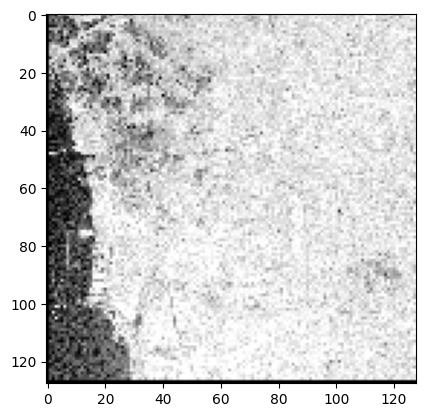

In [8]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the SAR Image is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 20]), cmap="gray")

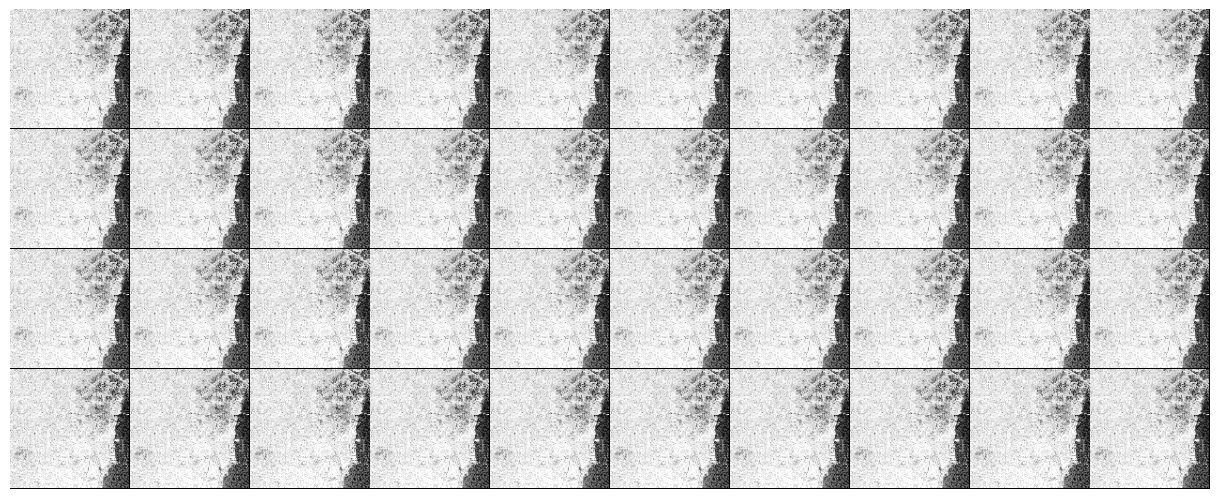

In [9]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of SAR Images"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

plot_slices(4, 10, 128, 128, image[:, :, :40])

In [10]:
def get_model(width=128, height=128, depth=64):
    inputs = keras.Input((width, height, depth, 1))
    # Initial Convolutional Layer
    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    # Convolutional Layer 1
    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    # Convolutional Layer 2
    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    # Fully Connected Layer
    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    # Output Layer
    outputs = layers.Dense(units=1, activation="sigmoid")(x)
    # Define the model
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model

# Build model
model = get_model(width=128, height=128, depth=64)
model.summary()


Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 126, 126, 62, 32)  896       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 63, 63, 31, 32)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 31, 32)   128       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 61, 61, 29, 64)    55360     
                                                             

In [11]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 150
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/150
2/2 - 21s - loss: 0.6667 - acc: 0.5625 - val_loss: 0.6918 - val_acc: 0.5000 - 21s/epoch - 10s/step
Epoch 2/150
2/2 - 1s - loss: 0.7283 - acc: 0.4375 - val_loss: 0.6918 - val_acc: 0.5000 - 813ms/epoch - 406ms/step
Epoch 3/150
2/2 - 1s - loss: 0.6922 - acc: 0.6875 - val_loss: 0.6915 - val_acc: 0.5000 - 821ms/epoch - 411ms/step
Epoch 4/150
2/2 - 1s - loss: 0.6711 - acc: 0.6250 - val_loss: 0.6920 - val_acc: 0.5000 - 822ms/epoch - 411ms/step
Epoch 5/150
2/2 - 1s - loss: 0.6419 - acc: 0.6250 - val_loss: 0.6924 - val_acc: 0.5000 - 818ms/epoch - 409ms/step
Epoch 6/150
2/2 - 1s - loss: 0.6058 - acc: 0.6250 - val_loss: 0.6921 - val_acc: 0.5000 - 811ms/epoch - 406ms/step
Epoch 7/150
2/2 - 1s - loss: 0.6305 - acc: 0.6250 - val_loss: 0.6920 - val_acc: 0.5000 - 813ms/epoch - 406ms/step
Epoch 8/150
2/2 - 1s - loss: 0.7021 - acc: 0.4375 - val_loss: 0.6919 - val_acc: 0.5000 - 806ms/epoch - 403ms/step
Epoch 9/150
2/2 - 1s - loss: 0.6913 - acc: 0.6250 - val_loss: 0.6915 - val_acc: 0.5000 - 84

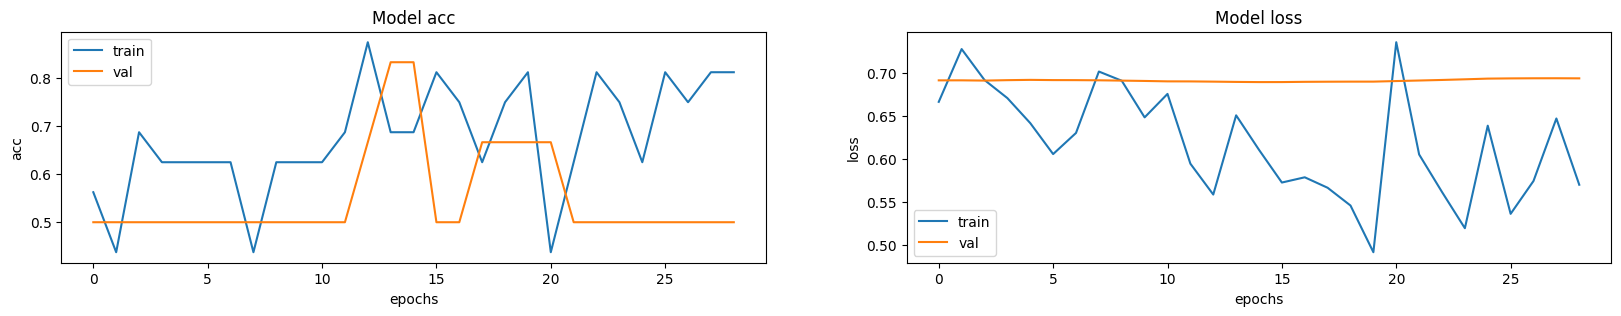

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [14]:
# Load best weights.
model.load_weights("3d_image_classification.h5")
prediction = model.predict(np.expand_dims(x_val[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["non-flood", "flood"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that SAR Image is %s"
        % ((100 * score), name)
    )

1/1 [==============================] - 0s 30ms/step
This model is 49.11 percent confident that SAR Image is non-flood
This model is 50.89 percent confident that SAR Image is flood
